In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import sys
import os
import pickle
%matplotlib widget

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('../..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.SimOptions import KDTestSource
from electronTransportCode.ParticleModel import DiffusionTestParticlev2
from electronTransportCode.MCParticleTracer import AnalogParticleTracer, KDParticleTracer
from electronTransportCode.MCEstimator import TrackEndEstimator


In [7]:
# Load all simulation results from data/
timingsK, timingsKD, scatteringRateList, dS = pickle.load(open('data/timings.pkl', 'rb'))
print(timingsK)
print(timingsKD)

[[  0.38676678   0.38582464   0.38584196   0.38682451   0.38725624]
 [  0.40957599   0.40886343   0.40809613   0.40882607   0.40850477]
 [  0.47524035   0.47552482   0.47485991   0.47568704   0.47592556]
 [  0.63782532   0.63899017   0.63788399   0.64140313   0.63893128]
 [  1.10389049   1.10052186   1.10183737   1.0996411    1.09997765]
 [  2.37456089   2.36799855   2.37494057   2.38124235   2.37175615]
 [  5.92082396   5.92621347   5.92421253   5.92673697   5.91758622]
 [ 15.74764804  15.76941789  15.67318885  15.7476036   15.73696282]
 [ 42.94810998  43.02838586  43.11333861  42.95519559  43.0629508 ]
 [118.80234128 118.76071101 118.79547959 118.75045903 118.88583453]]
[[0.40051117 0.40000907 0.40150883 0.40079409 0.4001991 ]
 [0.44066074 0.43957384 0.4399486  0.44126223 0.44113199]
 [0.54127174 0.54404338 0.54338054 0.54382961 0.54419039]
 [0.70562889 0.70419785 0.70465809 0.7046384  0.70506151]
 [0.84383046 0.84589909 0.84127354 0.84453007 0.84501855]
 [0.87098958 0.87148185 0.870

In [8]:
speedUp = timingsK/timingsKD
avgSpeedUp = speedUp.mean(axis=1)
varSpeedUp = speedUp.var(axis=1)

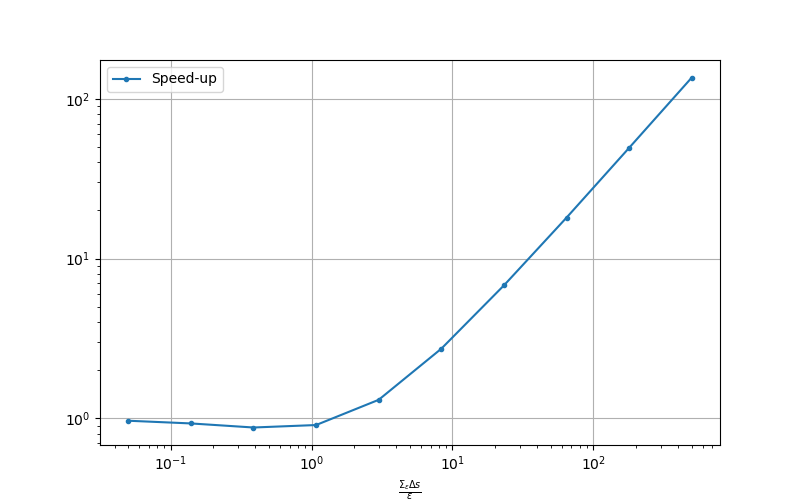

In [18]:
# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.0))

ax1.loglog(scatteringRateList*dS, avgSpeedUp, '.-', label='Speed-up')
ax1.set_xlabel('$ \\frac{ \Sigma_{\epsilon} \Delta s}{\epsilon}$')
ax1.legend()
ax1.grid()

In [19]:
varSpeedUp

array([4.74645580e-06, 2.59198474e-06, 2.28404437e-06, 4.65365955e-06,
       1.33425838e-05, 3.78630474e-05, 3.94961051e-04, 1.34717719e-03,
       2.37155479e-03, 1.25889527e-01])